In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_lyapunov, pinv, inv, solve_continuous_lyapunov
from joblib import Parallel, delayed
import multiprocessing


In [131]:
a_1 = np.array([[0.1, 0.4, 0.3],
              [0.2, 0.4, 0.3],
              [0.1, 0.3, 0.7]])
A_sym = np.array([
    [0.0, 0.8, 0.9, 0.0, 0.0], # node 1 (bridge node
    [0.8, 0.0, 0.0, 0.0, 0.0], # node 2 (leaf)
    [0.9, 0.0, 0.0, 0.9, 0.0], # node 3 (Middle node)
    [0.0, 0.0, 0.9, 0.0, 0.7], #node 4 (bridge) node)
    [0.0, 0.0, 0.0, 0.7, 0.0], #node 5 (leaf)
])

A = np.array([
    [0.0, 0.7, 0.8, 0.0, 0.0],  # strong bridge
    [0.5, 0.0, 0.0, 0.0, 0.0],  # leaf node
    [0.9, 0.0, 0.0, 0.6, 0.0],  # middle node
    [0.0, 0.0, 0.7, 0.0, 0.5],  # weaker bridge 
    [0.0, 0.0, 0.0, 0.6, 0.0],  # leaf node
])

n_nodes = 5
rng = np.random.default_rng(42)
#try without making symmetric
#A = (A + A.T) / 2
#np.fill_diagonal(A, 0)

eigvals = np.linalg.eigvals(A)
rho = max(abs(eigvals))
print("Spectral radius: ", rho)
# Scale to make it stable
A_stable = A * 0.9 / rho

eigvals = np.linalg.eigvals(A_stable)
print("Scaled radius: ", max(abs(eigvals)))

print("Stable adjacency matrix: ", A_stable)
T = 200  
C_i = np.zeros(n_nodes)

for i in range(n_nodes):
    b_i = np.zeros((n_nodes, 1))
    b_i[i, 0] = 1.0
    W_i = np.zeros((n_nodes, n_nodes))
    A_tau = np.eye(n_nodes)
    for t in range(T):
        #W_i_inf = solve_discrete_lyapunov(A_stable, b_i @ b_i.T)
        W_i += A_tau @ b_i @ b_i.T @ A_tau.T
        A_tau = A_stable @ A_tau
    C_i[i] = np.trace(W_i)

print("Ci values: ", C_i)

Spectral radius:  1.2132943513064482
Scaled radius:  0.9000000000000006
Stable adjacency matrix:  [[0.         0.51924745 0.59342566 0.         0.        ]
 [0.37089104 0.         0.         0.         0.        ]
 [0.66760387 0.         0.         0.44506924 0.        ]
 [0.         0.         0.51924745 0.         0.37089104]
 [0.         0.         0.         0.44506924 0.        ]]
Ci values:  [4.04343901 2.0901836  4.23864944 2.45502607 1.33771378]


Ci values:  [3.44719493 1.81656595 4.15067227 3.07832909 1.55828579]


In [132]:
N = 5
dt = 0.001
T = 40.0
steps = int(T / dt)
num_realizations = 200
k = 0.1
noise_amp = 0.8 # noise temperature
sigma = -0.2 * np.ones(N)     # >0 gives limit cycle which we dont want
alpha = np.ones(N)
beta  = np.ones(N)
omega = 2 * np.pi * np.ones(N)
a = A_stable

def g(xi, yi, alpha_i, beta_i):
    r2 = xi**2 + yi**2
    return 2 * alpha_i * beta_i * r2 - beta_i * r2**2

def one_realization_cov(node_idx):
    X = simulate_noise_response(node_idx)
    return np.cov(X, bias=True)

def simulate_noise_response(node_idx):
    """
    This function stimulates one single noise realization with noise injected the node with node_idx
    """

    x = np.zeros(N)
    y = np.zeros(N)
    traj = np.zeros((2*N, steps))

    U_noise = np.zeros((N, steps))
    Y_noise = np.zeros((N, steps))
    #wieners noise
    U_noise[node_idx] = noise_amp * np.sqrt(dt) * np.random.randn(steps)
    Y_noise[node_idx] = noise_amp * np.sqrt(dt) * np.random.randn(steps)

    for t in range(steps):
        #coupling_x = k * np.sum(a * (x[:, None] - x[None, :]), axis=1)
        #coupling_y = k * np.sum(a * (y[:, None] - y[None, :]), axis=1)
        coupling_x = k * np.sum(a * (x[None, :] - x[:, None]), axis=1)
        coupling_y = k * np.sum(a * (y[None, :] - y[:, None]), axis=1)
        
        g_vector = np.array([g(x[i], y[i], alpha[i], beta[i]) for i in range(N)])

        dx = -omega*y + x*(sigma + g_vector) + coupling_x + U_noise[:, t]
        dy =  omega*x + y*(sigma + g_vector) + coupling_y + Y_noise[:, t]
        #standard euler-maruyama
        x += dx * dt
        y += dy * dt

        traj[:N, t] = x
        traj[N:, t] = y

    return traj

def nonlinear_controllability(node_idx):
    """
    This function computes the nonlinear  controllability for one node using the noise trajectories.
    """
    n_jobs = multiprocessing.cpu_count()  
    covariances = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(one_realization_cov)(node_idx)
        for _ in range(num_realizations)
    )

    W_avg = np.mean(covariances, axis=0)

    # normalizing
    W_avg /= noise_amp**2

    return W_avg

node_controllability = np.zeros(N)

for i in range(N):
    W_i = nonlinear_controllability(i)
    eigvals = np.linalg.eigvalsh(W_i)
    print("Min eigenvalue: ", eigvals.min())
    node_controllability[i] = np.trace(W_i)
    #Ci = W_i[i, i] + W_i[i+N, i+N]
    #print("CI value: ",Ci)

for i, Ci in enumerate(node_controllability):
    print(f"Node {i+1} nonlinear controllability: {Ci:}")


Min eigenvalue:  3.255043805592984e-15
Min eigenvalue:  1.7201065005068955e-14
Min eigenvalue:  2.27404895410161e-16
Min eigenvalue:  3.183789506272496e-15
Min eigenvalue:  4.158468351757907e-15
Node 1 nonlinear controllability: 3.5384578536111326e-06
Node 2 nonlinear controllability: 4.51902151993464e-06
Node 3 nonlinear controllability: 3.4996825885556643e-06
Node 4 nonlinear controllability: 3.7218228214840846e-06
Node 5 nonlinear controllability: 4.490185299380875e-06


with symmetry:
Min eigenvalue:  3.3008842413110483e-15
Min eigenvalue:  8.751381708544202e-15
Min eigenvalue:  2.488450995055551e-16
Min eigenvalue:  4.022265871261446e-15
Min eigenvalue:  7.86429270903204e-15
Node 1 nonlinear controllability: 3.686695660202576e-06
Node 2 nonlinear controllability: 4.320398026980731e-06
Node 3 nonlinear controllability: 3.4284187125686007e-06
Node 4 nonlinear controllability: 3.831857921538752e-06
Node 5 nonlinear controllability: 4.580886289574761e-06
No symmetry:
Min eigenvalue:  3.1897738296343407e-15
Min eigenvalue:  1.6428500552990303e-14
Min eigenvalue:  2.170070810166203e-16
Min eigenvalue:  3.2656865089979233e-15
Min eigenvalue:  4.009544000009965e-15
Node 1 nonlinear controllability: 3.5434081202555054e-06
Node 2 nonlinear controllability: 4.4160294665409835e-06
Node 3 nonlinear controllability: 3.482160397422464e-06
Node 4 nonlinear controllability: 3.671689137803814e-06
Node 5 nonlinear controllability: 4.4388691640875505e-06

 Average g value: 2.9746171383754257e-06
 Average g value: 3.300267746772849e-06
 Average g value: 4.335129710437986e-06
 Average g value: 6.214699739878643e-06
 Average g value: 3.981069676037621e-06
 Average g value: 5.381771345278537e-06
 Average g value: 4.969765607056848e-06
 Average g value: 5.572501040111188e-06
 Average g value: 2.724283622142878e-06
 Average g value: 3.966522148655703e-06


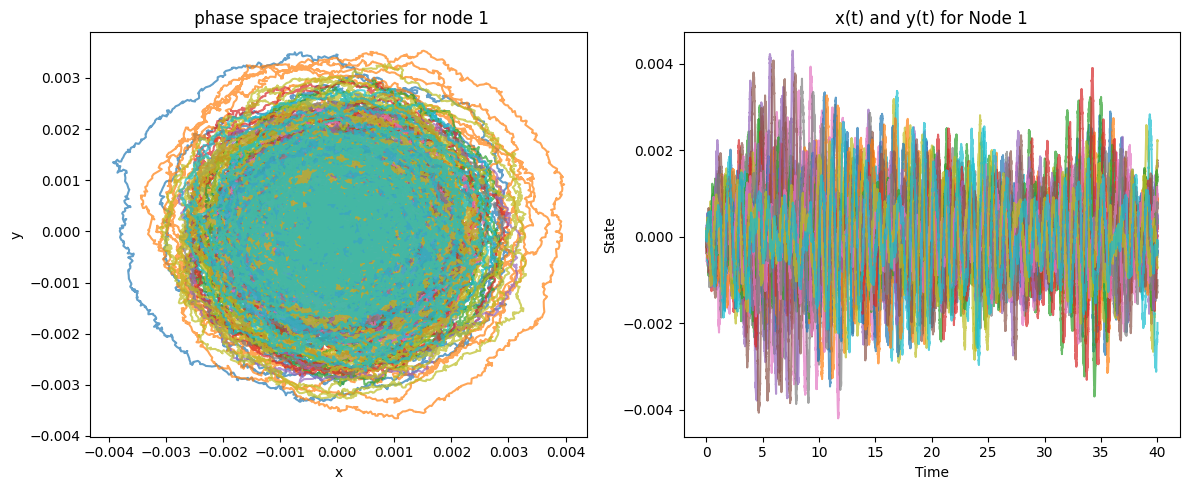

 Average g value: 6.200128870030816e-06
 Average g value: 6.4935824478204034e-06


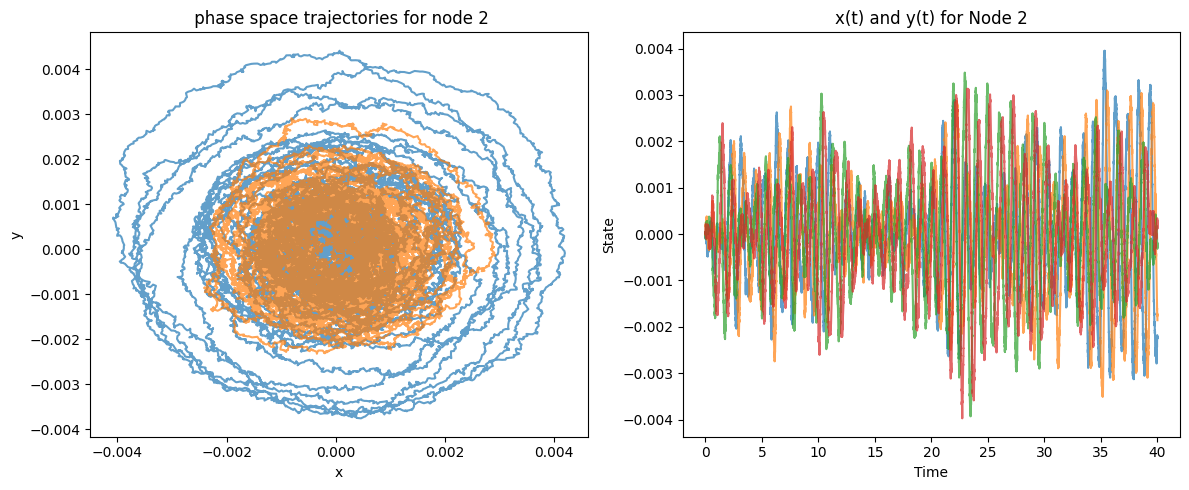

 Average g value: 7.6046497958904615e-06
 Average g value: 3.612724911571463e-06


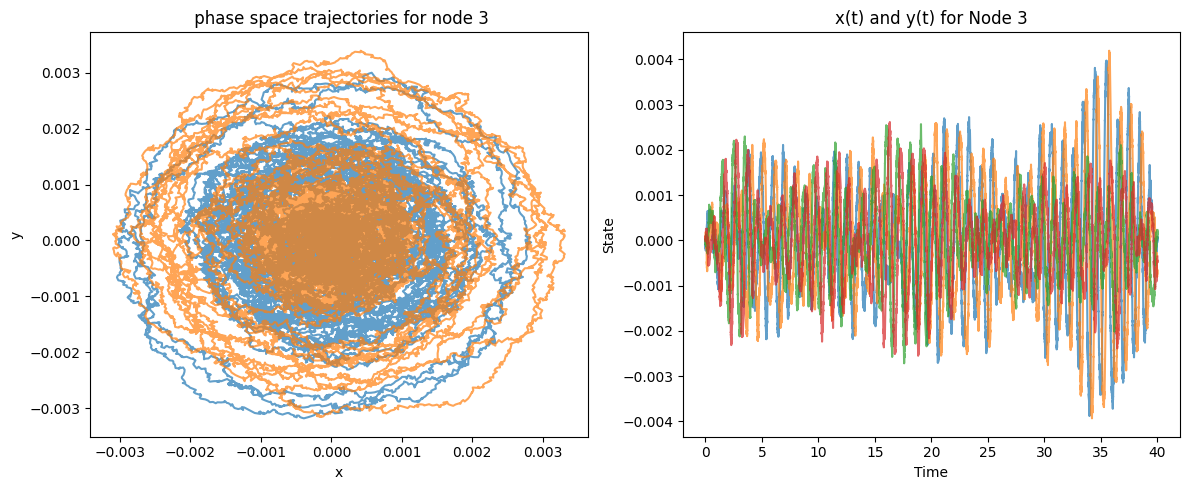

 Average g value: 3.66090993303813e-06
 Average g value: 3.994339804250645e-06


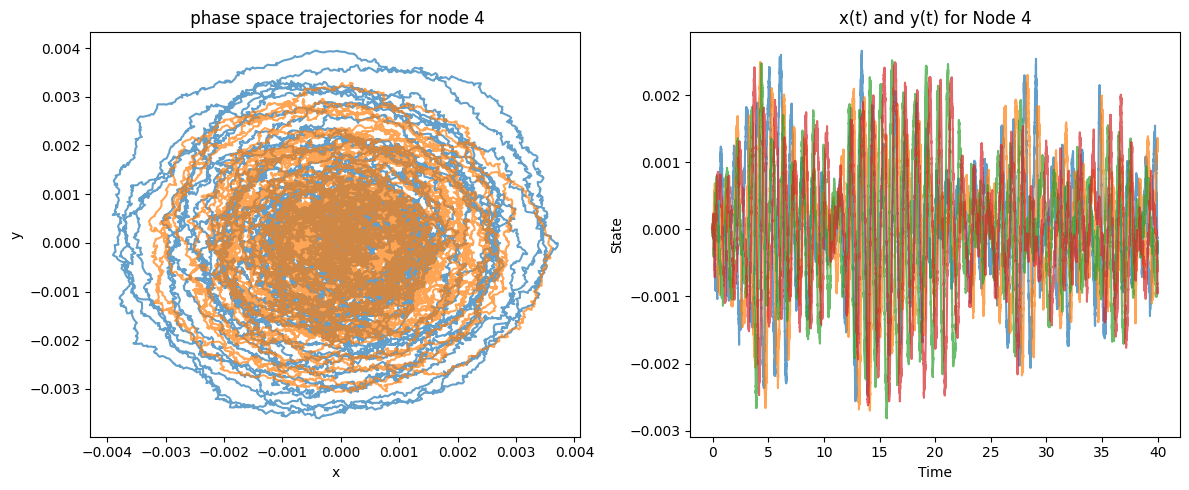

 Average g value: 5.855920989908657e-06
 Average g value: 6.003220115204704e-06


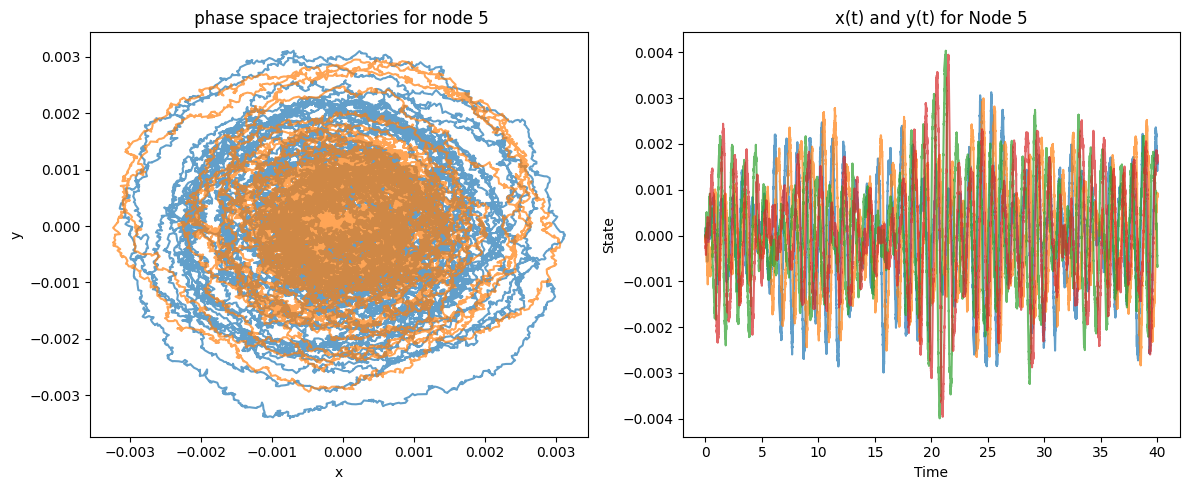

In [118]:
def plot_node_trajectories(node_idx, num_plot=5):
    """
    This function plots both the phase space and node states over time for a noise trajectory
    """
    plt.figure(figsize=(12, 5))

    # phase space plot
    plt.subplot(1, 2, 1)
    for _ in range(num_plot):
        traj = simulate_noise_response(node_idx)
        x = traj[node_idx, :]
        y = traj[N + node_idx, :]
        plt.plot(x, y, alpha=0.7)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f" phase space trajectories for node {node_idx+1}")

    # time series plot
    plt.subplot(1, 2, 2)
    for _ in range(num_plot):
        traj = simulate_noise_response(node_idx)
        x = traj[node_idx, :]
        y = traj[N + node_idx, :]
        r2 = x**2 + y**2
        g_vals = 2 * alpha[node_idx] * beta[node_idx] * r2 - beta[node_idx] * r2**2
        g_avg =  nonlinear_ratio = np.mean(np.abs(g_vals)) 
        print(f" Average g value: {g_avg}")
        #print(f"Sigma value: {sigma}")

        plt.plot(np.arange(steps) * dt, x, alpha=0.7)
        plt.plot(np.arange(steps) * dt, y, alpha=0.7)
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.title(f"x(t) and y(t) for Node {node_idx+1}")

    plt.tight_layout()
    plt.show()
plot_node_trajectories(0, num_plot=2)
plot_node_trajectories(1, num_plot=2)
plot_node_trajectories(2, num_plot=2)
plot_node_trajectories(3, num_plot=2)
plot_node_trajectories(4, num_plot=2)


 Average g value: 0.09091545607126993
 Average g value: 0.07501906918107745


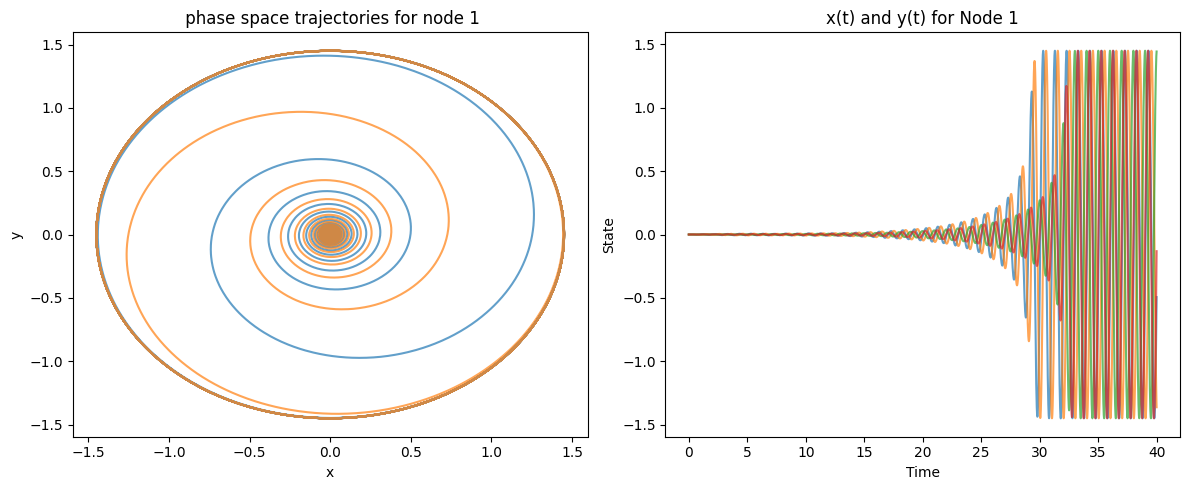

In [105]:
sigma = 0.2 * np.ones(N)
plot_node_trajectories(0, num_plot=2)


 Average g value: 1.4529752199789397e-05


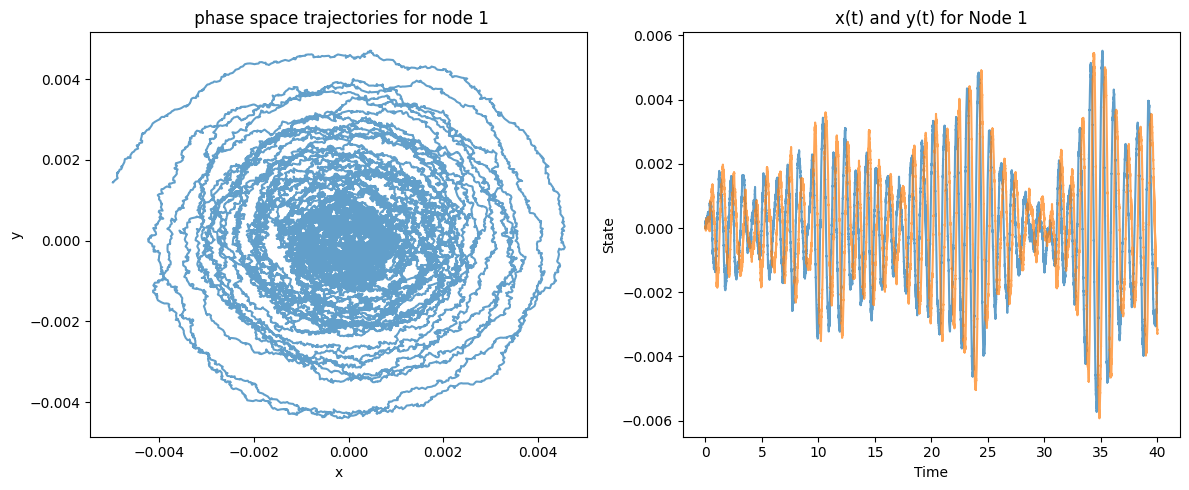

In [112]:
sigma = -0.0000002 * np.ones(N)
plot_node_trajectories(0, num_plot=2)

In [121]:
N = 5
dt = 0.001
T = 40.0
steps = int(T / dt)
num_realizations = 200
k = 0.1
noise_amp = 0.8 # noise temperature
sigma = -0.2 * np.ones(N)     # >0 gives limit cycle which we dont want
alpha = np.ones(N)
beta  = np.ones(N)
omega = 2 * np.pi * np.ones(N)
a = A_stable

def g(xi, yi, alpha_i, beta_i):
    r2 = xi**2 + yi**2
    return 2 * alpha_i * beta_i * r2 - beta_i * r2**2

def one_realization_cov(node_idx):
    X = simulate_noise_response(node_idx)
    return np.cov(X, bias=True)

def simulate_noise_response(node_idx):
    """
    This function stimulates one single noise realization with noise injected the node with node_idx
    """

    x = 2.0 * np.ones(N)
    y = np.zeros(N)
    traj = np.zeros((2*N, steps))

    U_noise = np.zeros((N, steps))
    Y_noise = np.zeros((N, steps))
    #wieners noise
    U_noise[node_idx] = noise_amp * np.sqrt(dt) * np.random.randn(steps)
    Y_noise[node_idx] = noise_amp * np.sqrt(dt) * np.random.randn(steps)

    for t in range(steps):
        #coupling_x = k * np.sum(a * (x[:, None] - x[None, :]), axis=1)
        #coupling_y = k * np.sum(a * (y[:, None] - y[None, :]), axis=1)
        coupling_x = k * np.sum(a * (x[None, :] - x[:, None]), axis=1)
        coupling_y = k * np.sum(a * (y[None, :] - y[:, None]), axis=1)
        
        g_vector = np.array([g(x[i], y[i], alpha[i], beta[i]) for i in range(N)])

        dx = -omega*y + x*(sigma + g_vector) + coupling_x + U_noise[:, t]
        dy =  omega*x + y*(sigma + g_vector) + coupling_y + Y_noise[:, t]
        #standard euler-maruyama
        x += dx * dt
        y += dy * dt

        traj[:N, t] = x
        traj[N:, t] = y

    return traj

def nonlinear_controllability(node_idx):
    """
    This function computes the nonlinear  controllability for one node using the noise trajectories.
    """
    n_jobs = multiprocessing.cpu_count()  
    covariances = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(one_realization_cov)(node_idx)
        for _ in range(num_realizations)
    )

    W_avg = np.mean(covariances, axis=0)

    # normalizing
    W_avg /= noise_amp**2

    return W_avg

node_controllability = np.zeros(N)

for i in range(N):
    W_i = nonlinear_controllability(i)
    eigvals = np.linalg.eigvalsh(W_i)
    print("Min eigenvalue: ", eigvals.min())
    node_controllability[i] = np.trace(W_i)
    #Ci = W_i[i, i] + W_i[i+N, i+N]
    #print("CI value: ",Ci)

for i, Ci in enumerate(node_controllability):
    print(f"Node {i+1} nonlinear controllability: {Ci:}")


Min eigenvalue:  6.682521815584716e-11
Min eigenvalue:  4.6628822777800983e-11
Min eigenvalue:  7.64186217052236e-12
Min eigenvalue:  3.110237543764228e-11
Min eigenvalue:  9.009294790527567e-12
Node 1 nonlinear controllability: 14.9132440572392
Node 2 nonlinear controllability: 14.913239148415153
Node 3 nonlinear controllability: 14.913239791805847
Node 4 nonlinear controllability: 14.913237677442915
Node 5 nonlinear controllability: 14.91323738179605


 Average g value: 0.18562655685954477
 Average g value: 0.18560359257576073
 Average g value: 0.18566112796878373
 Average g value: 0.18562232051406174


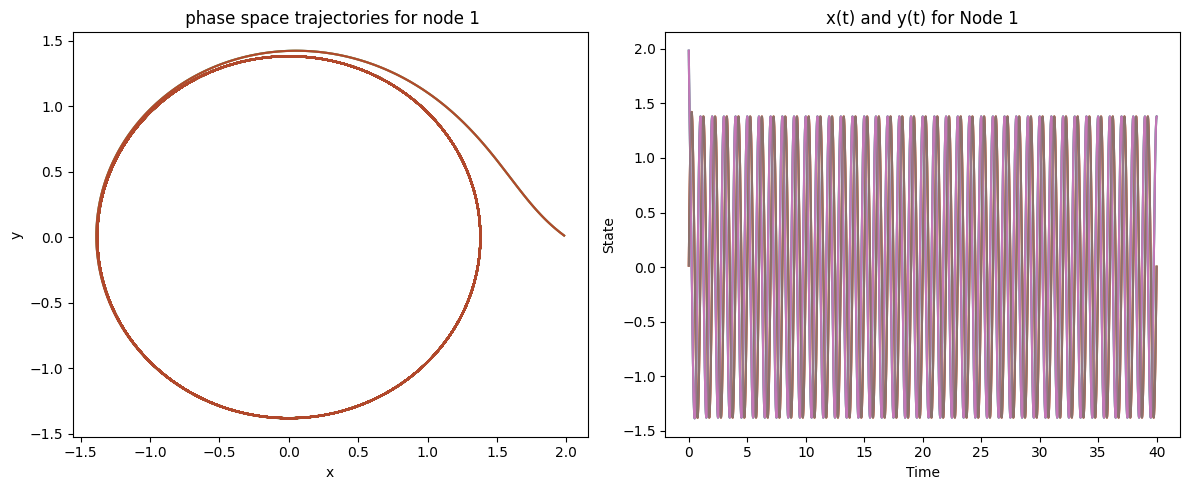

In [123]:
plot_node_trajectories(0, num_plot=4)